Praktikum zu Vorlesung
[__Modellreduktion parametrisierter Systeme__](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/)

Mario Ohlberger, Felix Schindler, Tim Keil

# Blatt 05, 22.05.2019

* Aktivieren Sie wie gewohnt ihre Arbeitsumgebung und starten Sie den Jupyter Notebook server, siehe zB [Blatt 1, Aufgabe 0](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/blatt_01__aufgaben.html#Aufgabe-0:-jupyter-Notebook-Server-starten).

* Erstellen Sie ein neues `Python 3` Notebook oder laden Sie dieses von der Homepage herunter.

* Importieren Sie `numpy` und `pymor.basic` und machen Sie `matplotlib` für das Notebook nutzbar.

In [1]:
%matplotlib notebook
import numpy as np
from pymor.basic import *

* Kopieren Sie alle benötigten Bestandteile für die Diskretisierung von Blatt 4 Aufgabe 2 und nennen Sie die Diskresierung `d`. Vergessen Sie nicht den `ParameterSpace`.

In [2]:
set_log_levels({'pymor': 'WARN'})

domain = RectDomain([[0,0],[1,1]], bottom='neumann')

diffusion_R = BitmapFunction('R.png', range=[1, 0])
diffusion_B = BitmapFunction('B.png', range=[1, 0])
diffusion = LincombFunction(
    [ConstantFunction(1., 2), diffusion_R, diffusion_B],
    [1., ExpressionParameterFunctional('-(1 - R)', {'R': ()}), ExpressionParameterFunctional('-(1 - B)', {'B': ()})]
)
problem = StationaryProblem(
    domain=domain,
    diffusion=diffusion,
    neumann_data=ConstantFunction(-1, 2),
    parameter_space=CubicParameterSpace(diffusion.parameter_type, 0.001, 1.)
)
d, _ = discretize_stationary_cg(problem, diameter=1/100)

00:00 |WARNING|BitmapFunction: Image R.png not in grayscale mode. Convertig to grayscale.
00:00 |WARNING|BitmapFunction: Image B.png not in grayscale mode. Convertig to grayscale.


* Erstellen Sie analog zu Blatt 04 Aufgabe 2 ein `VectorArray` $U$, das aus 30 zufälligen Lösungen besteht. 

In [3]:
U = d.solution_space.empty()
print(type(U))
for mu in d.parameter_space.sample_randomly(30):
    U.append(d.solve(mu))

<class 'pymor.vectorarrays.numpy.NumpyVectorArray'>


## Aufgabe 1:  Orthogonale Projektionen

Wir wollen nun den Begriff der Orthogonalen Projektionen behandeln. 

Sei dafür $U$ ein beliebiges `VectorArray` und $V$ ein `VectorArray` gleicher Dimension der Länge 1. Sei außerdem $v_{proj}$ die orthogonale Projektion von $v$ auf den von den Vektoren in $U$ aufgespannten Vektorraum. Dann ist $v - v_{proj}$ orthogonal zu diesem Raum und insbesondere zu jedem Vektor aus $U$. Sind $u_i$, $i = 1, \ldots, N$ die Vektoren in $U$, so gilt also:

$$(v - v_{proj}, u_i) = 0, \qquad i = 1, \ldots, N.$$

Sind nun $\lambda_j$, $j = 1, \ldots, N$ die Koeffizienten von $v_{proj}$ bezüglich der $u_j$ basis, d.h. $\sum_{j=1}^N \lambda_j u_j = v_{proj}$, so folgt:

$$ \sum_{j=1}^N \lambda_j (u_i, u_j) = (v, u_i), \qquad i = 1, \ldots, N.$$

Setzten wir $M_{i,j} := (u_i, u_j)$, $R := [(v, u_1), \ldots, (v, u_N)]^T$ und $\Lambda := [\lambda_1, \ldots, \lambda_N]^T$, so erhalten wir das lineare Gleichungssystem

$$ M \cdot \Lambda = R,$$

mit dem wir die Koeffizienten $\lambda_i$ und somit $v_{proj}$ bestimmen können.

1. Assemblieren und Lösen Sie für das `Vectorarray` $U$ von Blatt 4 Aufabe 2 und ein `Vectorarray` $V$, welches eine weitere Lösung von `d` enthält. Hinweis: Benutzen Sie die `gramian`-Methode für die Matrix $M$.

In [4]:
V = d.solve(d.parameter_space.sample_randomly(1, seed=99)[0])
M = U.gramian()
rhs = U.dot(V)  # beachte die Reihenfolge von U und V um einen Spaltenvektor zu erhalten!
v = np.linalg.solve(M, rhs)

* Bemerkung: Jedes `VectorArray` besitzt eine `gramian`-Methode, welche gerade die oben definierte Gram-Matrix $M$ bezüglich des Euklidischen Skalarprodukts berechnet. `gramian` ist ein Spezialfall der allgemeineren `dot`-Methode, die im Falle von `U.dot(V)` die Matrix $(u_i, v_j)$ aller Euklidischen Skalarprodukte zwischen den Vektoren in `U` und `V` berechnet. 

2. Formen Sie die Linearkombination der Koeffizienten mit den Basisvektoren in $U$ um $v_{proj}$ zu berechnen. 

In [5]:
V_proj = U.lincomb(v.T)  # hier wird ein Zeilenvektor von Koeffizienten erwartet!

* Bemerkung: Die Linearkombination $\sum_{j=1}^N \lambda_j u_j$ kann in pyMOR effizient mit der `lincomb`-Methode von `U` bestimmt werden. Diese erwartet ein 1D- oder 2D-Array von Koeffizienten $\lambda_j$. (Im Falle eines 2D-Arrays entspricht dabei jede Zeile einer Folge von Linearkoeffizienten und es werden die entsprechenden Linearkombinationen für jede Zeile des Arrays zurückgeliefert.)

3. Visualisieren Sie das Ergebnis zusammen mit $V$. Visualisieren Sie auch den Projektionsfehler.

<IPython.core.display.Javascript object>


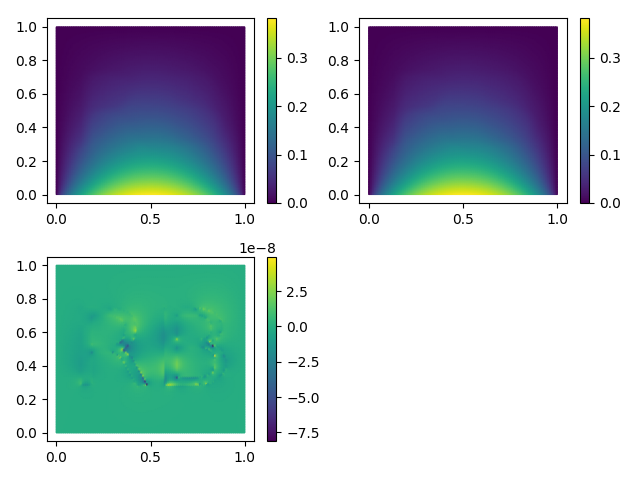

In [6]:
d.visualize((V, V_proj, V - V_proj), separate_colorbars=True)

* Bemerkung: Wird `visualize` ein Tupel von `VectorArrays` übergeben, wird ein Plot für jedes Array generiert. Der `separate_colorbars` Parameter legt fest, ob alle Plots mit der gleichen Colorbar skaliert werden sollen:

4. Wiederholen Sie 1.-3. für die $H^1_0$-Projektion auf $U$. Hinweis: Benutzen Sie das entsprechende Produkt aus `d`.

<IPython.core.display.Javascript object>


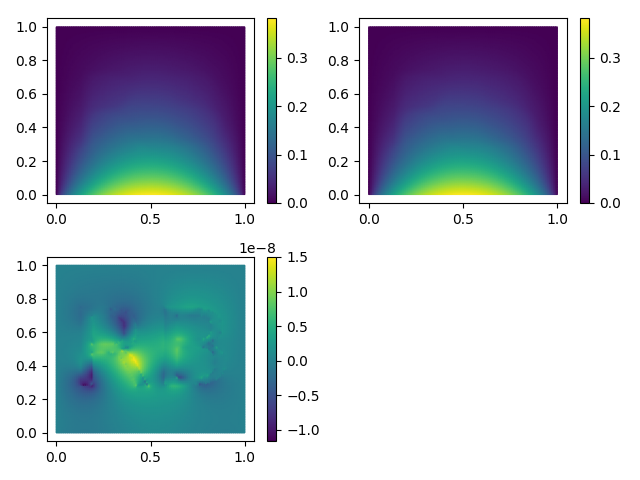

In [7]:
M = U.gramian(product=d.h1_0_semi_product)
rhs = d.h1_0_semi_product.apply2(U, V)
v = np.linalg.solve(M, rhs)
V_h1_proj = U.lincomb(v.T)

d.visualize((V, V_h1_proj, V - V_h1_proj), separate_colorbars=True)

* Bemerkung: Um die Matrix $M$ mit dem korrekten Skalarprodukt zu berechnen verwenden wir die `apply2`-Methode des entsprechenden Skalarprodukt-Operators. Dabei ist `op.apply2(U, V)` gerade äquivalent zu `U.dot(op.apply(V))`. Ist also `op` durch eine Matrix `P` gegeben und fassen wir `U`, `V` als Matrizen von Spaltenvektoren auf, so erhalten wir gerade die Matrix
$ U^T \cdot P \cdot V$.

5. Berechnen Sie die Euklidische, $H^1_0$, sowie $L^2$ Norm für beide Projektionsfehler

In [8]:
for norm_name, norm in [('eukld.', None), ('H^1_0', d.h1_0_semi_norm), ('L^2', d.l2_0_norm)]:
    print('{:<16}'.format(norm_name + '-Norm:'), end='')
    for proj_name, VV in [('eukld.', V_proj), ('H^1_0', V_h1_proj)]:
        if norm is None:
            err = ((V - VV).l2_norm() / V.l2_norm())[0]
        else:
            err = (norm(V - VV) / norm(V))[0]
        print('{}: {:.2e}    '.format(proj_name, err), end='')
    print()

eukld.-Norm:    eukld.: 3.70e-08    H^1_0: 2.31e-08    
H^1_0-Norm:     eukld.: 9.51e-07    H^1_0: 1.35e-07    
L^2-Norm:       eukld.: 3.58e-08    H^1_0: 2.33e-08    


6. Erstellen Sie nun einen `VectorArray` V mit 100 zufällig gewählten Lösungen von `d`. 

In [9]:
V = d.solution_space.empty()
for mu in d.parameter_space.sample_randomly(100, seed=99):
    V.append(d.solve(mu))
    print('.', end='', flush=True)

....................................................................................................

7. Berechnen Sie für $V$ die maximalen Projektionsfehler auf die ersten $N$ Vektoren in U.  
    - Hinweis: Die Berechnung der Projektions-Matrix und rechten Seite für verschiedene Basisgrößen können wir optimieren, indem wir diese zunächst für die volle Basis berechnen und dann entsprechend ausschneiden. Wie bei Numpy-Arrays können wir auch bei `VectorArrays` `slicing` verwenden. Dabei erhalten wir ebenfalls einen View in das Original-Array. Es wird kein Kopie der Daten erzeugt.

In [10]:
M = d.h1_0_semi_product.apply2(U, U)
rhs = d.h1_0_semi_product.apply2(U, V)
errors = []
for N in range(len(U)):
    try:
        v = np.linalg.solve(M[:N, :N], rhs[:N, :])
    except np.linalg.LinAlgError:
        v = np.zeros((N, len(V)))
    V_proj = U[:N].lincomb(v.T)
    errors.append(np.max(d.h1_0_semi_norm(V - V_proj)))

* Bemerkung: Je nach Problem kann es passieren, dass die Vektoren in `U` (numerisch) linear abhängig werden. In diesem Fall schlägt der Aufruf von `np.linalg.solve` mit einer `np.linalg.LinalgError`-Exception fehl. Dies fangen wir in dem `try`-`except`-Block ab und setzen in diesem Fall `V_proj` auf 0.

8. Plotten Sie die Projektionsfehler in Abhängigkeit von $N$ in einem semilog-plot. 

<IPython.core.display.Javascript object>


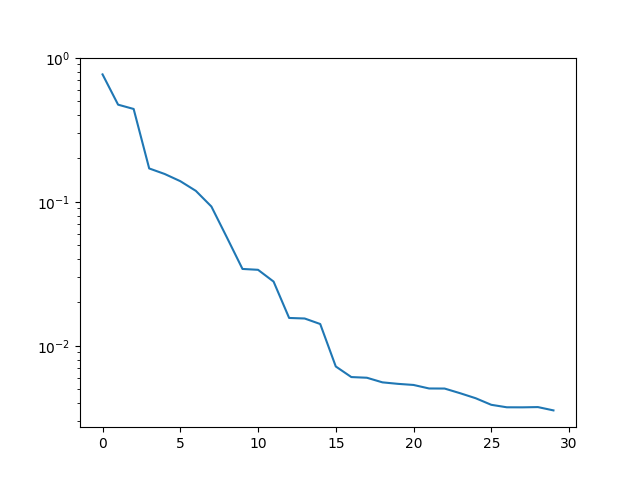

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.semilogy(errors)
plt.show()

9. Berechnen Sie die Kondition der Projektionsmatrizen in Abhängigkeit von $N$ und plotten Sie das Ergebnise

<IPython.core.display.Javascript object>


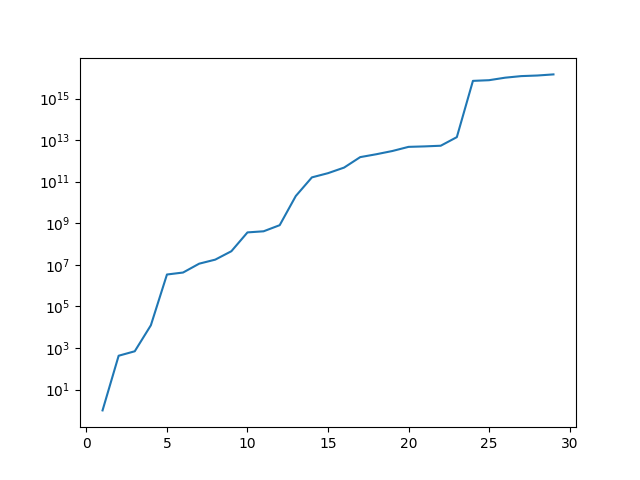

In [12]:
conds = []
for N in range(1, len(U)):
    conds.append(np.linalg.cond(M[:N, :N]))
plt.figure()
plt.semilogy(range(1, len(U)), conds)
plt.show()

## Aufgabe 2: Greedy Algorithmus

Der folgende Pseudocode definiert den Greedy-Algorithmus in der ursprünglichen Form. 

Input: Menge von Vektoren $\mathcal{M} \subset V$, Ziel-Basisgröße $N$.
Output: Basis $b_1, \dots, b_N$

$\texttt{for } n:=1 \texttt{ to } N:$ 
$$ \hspace{-10em} b_n := \text{argmax}_{m \in \mathcal{M}} \Vert m - P_{\text{span}(b_1,\dots,b_n)}(m) \Vert$$
$\texttt{endfor}$

1. Implementieren Sie den oben definierten Greey-Algorithmus mit den folgenden Argumenten:
    * Das `VectorArray` $\mathcal{M}$ welches eine Menge von Vektoren enthält. 
    * ein Skalarprodukt auf $V$.
    * eine Ziel-Basisgröße $N$.
    
Hinweis: Wollen wir mit Hilfe eines Skalarprodukt-Operators Normen berechnen, können wir statt `apply2` die `pairwise_apply2`-Methode verwenden, die gerade die Diagonale der von `apply2` berechneten Matrix zurückliefert

In [13]:
def greedy(M, product, N):
    basis = M.space.empty()
    max_errors = []
    for n in range(N):
        lhs = product.apply2(basis, basis)
        rhs = product.apply2(basis, M)
        try:
            m = np.linalg.solve(lhs, rhs)
        except np.linalg.LinAlgError:
            break
        M_proj = basis.lincomb(m.T)
        M_err = M - M_proj
        errors = np.sqrt(product.pairwise_apply2(M_err, M_err))
        max_errors.append(np.max(errors))
        basis.append(M[np.argmax(errors)])
    return basis

2. Wenden Sie Ihren Algorithmus auf das `VectorArray` $U$ von oben mit $N=30$ und einem geeigneten Produkt an.

In [14]:
greedy_basis = greedy(U, d.h1_0_product, 30)

3. Berechnen Sie die Projektionsfehler und Konditionen wie in Aufgabe 1 Teilaufgabe 8. und 9. Vergleichen Sie das Ergebnis mit den Ergebnissen aus Aufabe 1.   

<IPython.core.display.Javascript object>


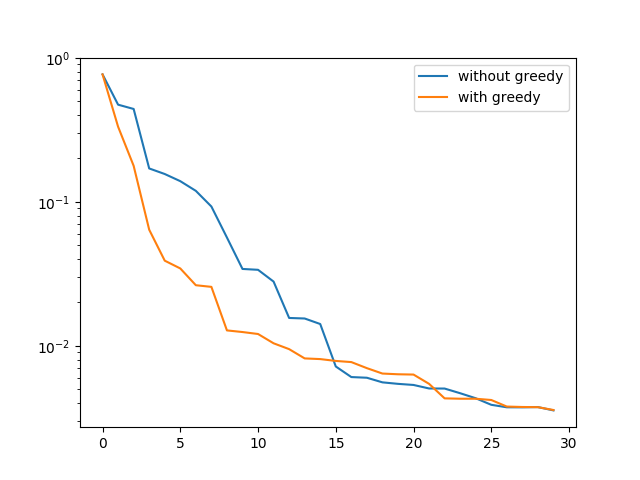

In [15]:
M_greedy = d.h1_0_semi_product.apply2(greedy_basis, greedy_basis)
rhs = d.h1_0_semi_product.apply2(greedy_basis, V)
greedy_proj_errors = []
for N in range(len(greedy_basis)):
    try:
        v = np.linalg.solve(M_greedy[:N, :N], rhs[:N, :])
    except np.linalg.LinAlgError:
        v = np.zeros((N, len(V)))
    V_proj = greedy_basis[:N].lincomb(v.T)
    greedy_proj_errors.append(np.max(d.h1_0_semi_norm(V - V_proj)))

plt.figure()
plt.semilogy(errors, label='without greedy')
plt.semilogy(greedy_proj_errors, label='with greedy')
plt.legend()
plt.show()

Schließlich noch die Konditionen der Projektions-Matrizen:

<IPython.core.display.Javascript object>


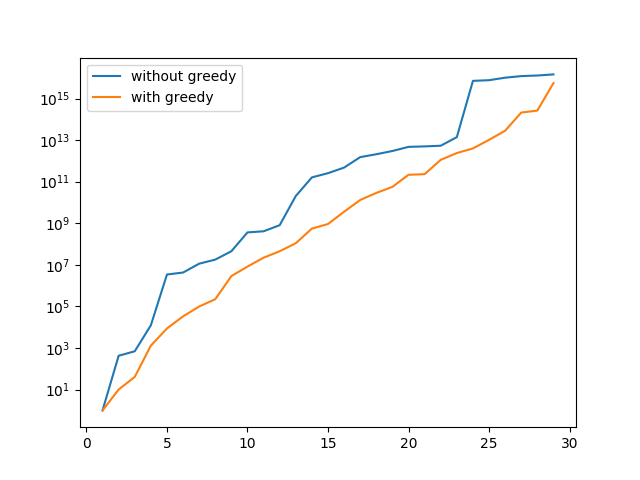

In [16]:
greedy_conds = []
for N in range(1, len(U)):
    greedy_conds.append(np.linalg.cond(M_greedy[:N, :N]))
plt.figure()
plt.semilogy(range(1, len(U)), conds, label='without greedy')
plt.semilogy(range(1, len(U)), greedy_conds, label='with greedy')
plt.legend()
plt.show()